**Общая информация**

**Срок сдачи:** 16 марта 2020, 08:30 

**Штраф за опоздание:** по 1 баллу за 24 часа задержки. Через 5 дней домашнее задание сгорает.

При отправлении ДЗ указывайте фамилию в названии файла
Присылать ДЗ необходимо в виде ссылки на свой github репозиторий на почту ml1.sphere@mail.ru с указанием темы в следующем формате:

[ML0220, Задание 1] Фамилия Имя.

Используйте данный Ipython Notebook при оформлении домашнего задания.


**Штрафные баллы:**

1. Отсутствие фамилии в имени скрипта (скрипт должен называться по аналогии со stroykova_hw1.ipynb) -0.5 баллов
2. Все строчки должны быть выполнены. Нужно, чтобы output команды можно было увидеть уже в git'е. В противном случае -0.5 баллов


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import seaborn as sns
from sklearn import datasets
from sklearn.base import BaseEstimator
from sklearn.datasets import fetch_mldata, fetch_20newsgroups

from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier, KDTree
from sklearn.metrics import accuracy_score, pairwise_distances_chunked
from scipy.spatial.distance import cdist, squareform
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import cross_val_score
from sklearn.utils import check_array
from scipy import sparse
from functools import partial

##### Задание 1 (1 балл)
Реализовать KNN в классе MyKNeighborsClassifier (обязательное условие: точность не ниже sklearn реализации)
Разберитесь самостоятельно, какая мера расстояния используется в KNeighborsClassifier дефолтно и реализуйте свой алгоритм именно с этой мерой. 
Для подсчета расстояний можно использовать функции [отсюда](https://docs.scipy.org/doc/scipy/reference/spatial.distance.html)

In [2]:
class MyKNeighborsClassifier(BaseEstimator):
    
    def __init__(self, n_neighbors, algorithm, metric = 'euclidean'):
        self.n_neighbors = n_neighbors
        self.X_train = None
        self.y_train = None
        self.alg = algorithm
        self.metric = metric
    def fit(self, X, y):
        if sparse.issparse(X):
            self.X_train = check_array(X, accept_sparse='csr')
        else:
            self.X_train = X
        self.y_train = y
        if self.alg == 'kd_tree':
            self.tree = KDTree(self.X_train)
    def _kneighbors_reduce_func(self, dist, start, n_neighbors):
        #цитаты классиков
        sample_range = np.arange(dist.shape[0])[:, None]
        neigh_ind = np.argpartition(dist, n_neighbors - 1, axis=1)
        neigh_ind = neigh_ind[:, :n_neighbors]
        neigh_ind = neigh_ind[sample_range, np.argsort(dist[sample_range, neigh_ind])]
        return neigh_ind
    def predict(self, X):
        k = self.n_neighbors
        if self.alg == 'brute':
            if sparse.issparse(X):
                X = check_array(X, accept_sparse='csr')
                reduce_func = partial(self._kneighbors_reduce_func, n_neighbors=k)
                chunked_results = list(pairwise_distances_chunked(X, self.X_train, 
                                                                  reduce_func=reduce_func, 
                                                                  metric = self.metric))
                results = np.vstack(chunked_results)
                index_of_k = results
            else:
                dist = cdist(X, self.X_train, 'minkowski', p=2)
                index_of_k = np.argpartition(dist, k, axis = 1)[:, :k]
        elif self.alg == 'kd_tree':
            index_of_k = self.tree.query(X, k, return_distance=False)
        res = [-1] * X.shape[0]
        for i in range(X.shape[0]):
            counts = np.bincount(self.y_train[index_of_k[i]])
            res[i] = np.argmax(counts)
        return np.asarray(res)
            

**IRIS**

В библиотеке scikit-learn есть несколько датасетов из коробки. Один из них [Ирисы Фишера](https://ru.wikipedia.org/wiki/%D0%98%D1%80%D0%B8%D1%81%D1%8B_%D0%A4%D0%B8%D1%88%D0%B5%D1%80%D0%B0)

In [3]:
iris = datasets.load_iris()

In [4]:
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, test_size=0.1, stratify=iris.target)

In [5]:
clf = KNeighborsClassifier(n_neighbors=2, algorithm='brute')
my_clf = MyKNeighborsClassifier(n_neighbors=2, algorithm='brute')

In [6]:
clf.fit(X_train, y_train)
my_clf.fit(X_train, y_train)

In [7]:
sklearn_pred = clf.predict(X_test)
my_clf_pred = my_clf.predict(X_test)
assert abs( accuracy_score(y_test, my_clf_pred) -  accuracy_score(y_test, sklearn_pred ) )<0.005, "Score must be simillar"

**Задание 2 (0.5 балла)**

Давайте попробуем добиться скорости работы на fit, predict сравнимой со sklearn для iris. Допускается замедление не более чем в 2 раза. 
Для этого используем numpy. 

In [8]:
%time clf.fit(X_train, y_train)

Wall time: 0 ns


KNeighborsClassifier(algorithm='brute', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=2, p=2,
                     weights='uniform')

In [9]:
%time my_clf.fit(X_train, y_train)

Wall time: 0 ns


In [10]:
%time clf.predict(X_test)

Wall time: 5.83 ms


array([2, 0, 2, 2, 2, 0, 1, 0, 0, 2, 2, 1, 1, 0, 1])

In [11]:
%time my_clf.predict(X_test)

Wall time: 1.41 ms


array([2, 0, 2, 2, 2, 0, 1, 0, 0, 2, 2, 1, 1, 0, 1], dtype=int64)

###### Задание 3 (1 балл)
Добавьте algorithm='kd_tree' в реализацию KNN (использовать KDTree из sklearn.neighbors). Необходимо добиться скорости работы на fit,  predict сравнимой со sklearn для iris. Допускается замедление не более чем в 2 раза. 
Для этого используем numpy. Точность не должна уступать значению KNN из sklearn. 

In [12]:
clf = KNeighborsClassifier(n_neighbors=2, algorithm='kd_tree')
my_clf = MyKNeighborsClassifier(n_neighbors=2, algorithm='kd_tree')

In [13]:
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, test_size=0.1, stratify=iris.target)

In [14]:
%time clf.fit(X_train, y_train)

Wall time: 0 ns


KNeighborsClassifier(algorithm='kd_tree', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=2, p=2,
                     weights='uniform')

In [15]:
%time my_clf.fit(X_train, y_train)

Wall time: 0 ns


In [16]:
%time clf.predict(X_test)

Wall time: 990 µs


array([0, 2, 1, 2, 0, 2, 0, 2, 1, 2, 1, 1, 0, 1, 0])

In [17]:
%time my_clf.predict(X_test)

Wall time: 998 µs


array([0, 2, 1, 2, 0, 2, 0, 2, 1, 2, 1, 1, 0, 1, 0], dtype=int64)

In [18]:
sklearn_pred = clf.predict(X_test)
my_clf_pred = my_clf.predict(X_test)
assert abs( accuracy_score(y_test, my_clf_pred) -  accuracy_score(y_test, sklearn_pred ) )<0.005, "Score must be simillar"

**Задание 4 (2.5 балла)**

Рассмотрим новый датасет 20 newsgroups

In [19]:
newsgroups = fetch_20newsgroups(subset='train',remove=['headers','footers', 'quotes'])

In [20]:
data = newsgroups['data']
target = newsgroups['target']

In [21]:
len(data)

11314

Преобразуйте текстовые данные из data с помощью [CountVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html). Словарь можно ограничить по частотности.

In [22]:
vectorizer = CountVectorizer(max_df = 0.5)

In [23]:
data_mtx = vectorizer.fit_transform(data)

In [24]:
data_mtx

<11314x101622 sparse matrix of type '<class 'numpy.int64'>'
	with 1036541 stored elements in Compressed Sparse Row format>

*Так мы получили векторное представление наших текстов. Значит можно приступать к задаче обучения модели*

Реализуйте разбиение выборки для кросс-валидации на 3 фолдах. Разрешено использовать sklearn.cross_validation

In [25]:
kf = KFold(n_splits=3)
for train_index, test_index in kf.split(data_mtx):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = data_mtx[train_index], data_mtx[test_index]

TRAIN: [ 3772  3773  3774 ... 11311 11312 11313] TEST: [   0    1    2 ... 3769 3770 3771]
TRAIN: [    0     1     2 ... 11311 11312 11313] TEST: [3772 3773 3774 ... 7540 7541 7542]
TRAIN: [   0    1    2 ... 7540 7541 7542] TEST: [ 7543  7544  7545 ... 11311 11312 11313]


Напишите метод, позволяющий найти оптимальное количество ближайших соседей(дающее максимальную точность в среднем на валидации на 3 фолдах).
Постройте график зависимости средней точности от количества соседей. Можно рассмотреть число соседей от 1 до 10.

In [26]:
def model_parameters(x_train, x_target, metric = 'euclidean'):
    kf = KFold(n_splits=3)
    k_scores = {}
    for k in range(1, 11):
        my_clf = MyKNeighborsClassifier(n_neighbors=k, algorithm='brute', metric = metric)
        ac_score = []
        for train_index, test_index in kf.split(x_train):
            X_train, X_test = x_train[train_index], x_train[test_index]
            my_clf.fit(X_train, x_target[train_index])
            my_clf_pred = my_clf.predict(X_test)
            score = accuracy_score(x_target[test_index], my_clf_pred)
            ac_score.append(score)
        k_scores[k] = np.mean(np.asarray(ac_score))
    return k_scores
    

In [27]:
k_score = model_parameters(data_mtx, target)
models = pd.DataFrame(data = k_score, index = [0])
models['model'] = 'CountVectorizer(max_df = 0.5), metric = euclidean'

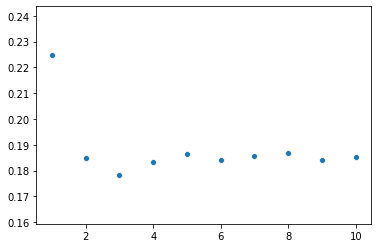

In [28]:
sns.scatterplot(x = models.columns[:10], y = models.values[0][:10])

Как изменится качество на валидации, если:

1. Используется косинусная метрика вместо евклидовой.
2. К текстам применяется TfIdf векторизацию( sklearn.feature_extraction.text.TfidfVectorizer)

Сравните модели, выберите лучшую.

In [29]:
def model_chooser(vectorizer_type, max_df, train_data, target_data, metric):
    if vectorizer_type == 'tfidf':
        vectorizer = TfidfVectorizer(max_df = max_df)
    else:
        vectorizer = CountVectorizer(max_df = max_df)
    mtx = vectorizer.fit_transform(train_data)
    k_score = model_parameters(mtx, target_data, metric = metric)
    df = pd.DataFrame(data = k_score, index = [0])
    df['model'] = 'vectorizer = ' + vectorizer_type + '; max_df = ' + str(max_df) + '; metric = ' + metric
    return df

In [30]:
k_score_df = model_chooser(vectorizer_type = 'count', max_df = 0.5, train_data = data, target_data = target, metric = 'cosine')
models = models.append(k_score_df, ignore_index = True)

In [31]:
k_score_df = model_chooser(vectorizer_type = 'tfidf', max_df = 0.5, train_data = data, target_data = target, metric = 'euclidean')
models = models.append(k_score_df, ignore_index = True)

In [32]:
k_score_df = model_chooser(vectorizer_type = 'tfidf', max_df = 0.5, train_data = data, target_data = target, metric = 'cosine')
models = models.append(k_score_df, ignore_index = True)

In [33]:
k_score_df = model_chooser(vectorizer_type = 'tfidf', max_df = 0.6, train_data = data, target_data = target, metric = 'cosine')
models = models.append(k_score_df, ignore_index = True)

In [34]:
k_score_df = model_chooser(vectorizer_type = 'tfidf', max_df = 0.4, train_data = data, target_data = target, metric = 'cosine')
models = models.append(k_score_df, ignore_index = True)

In [35]:
models

,1,2,3,4,5,6,7,8,9,10,model
0,0.224678,0.184726,0.178362,0.183312,0.186317,0.183931,0.185787,0.186847,0.184196,0.185257,"CountVectorizer(max_df = 0.5), metric = euclidean"
1,0.390489,0.358317,0.361411,0.362117,0.361410,0.365918,0.369100,0.369806,0.371663,0.374756,vectorizer = count; max_df = 0.5; metric = cosine
2,0.135054,0.082111,0.074421,0.086176,0.083171,0.083259,0.081668,0.078575,0.077957,0.075924,vectorizer = tfidf; max_df = 0.5; metric = euc...
3,0.622857,0.584850,0.605003,0.614284,0.624625,0.625862,0.629397,0.632491,0.633463,0.633463,vectorizer = tfidf; max_df = 0.5; metric = cosine
4,0.621797,0.583524,0.601025,0.608715,0.613930,0.620294,0.623475,0.624359,0.626481,0.625332,vectorizer = tfidf; max_df = 0.6; metric = cosine
5,0.625155,0.586176,0.610483,0.622857,0.630989,0.633022,0.637175,0.637441,0.637970,0.638589,vectorizer = tfidf; max_df = 0.4; metric = cosine


In [36]:
#лучшая модель TfidfVectorizer(max_df = 0.4), metric = cosine, k = 10, натренируем её на всей обучающей выборке
vectorizer = TfidfVectorizer(max_df = 0.4)
data_mtx = vectorizer.fit_transform(data)

In [37]:
my_clf = MyKNeighborsClassifier(n_neighbors=10, algorithm='brute', metric = 'cosine')
my_clf.fit(data_mtx, target)

Загрузим  теперь test  часть нашей выборки и преобразуем её аналогично с train частью. Не забудьте, что наборы слов в train и test части могут отличаться.

In [38]:
newsgroups_test = fetch_20newsgroups(subset='test',remove=['headers','footers', 'quotes'])

Оценим точность вашей лучшей модели на test части датасета. Отличается ли оно от кросс-валидации? Попробуйте сделать выводы, почему отличается качество.

In [39]:
data_test = newsgroups_test['data']
target_test = newsgroups_test['target']

In [40]:
voc = vectorizer.vocabulary_

In [41]:
vectorizer_test = TfidfVectorizer(max_df = 0.4, vocabulary = voc)

In [42]:
data_mtx_test = vectorizer_test.fit_transform(data_test)

In [43]:
my_clf_pred = my_clf.predict(data_mtx_test)
score = accuracy_score(target_test, my_clf_pred)

In [44]:
score

0.5743494423791822

In [45]:
"""

Качество меньше, чем на кросс-валидации, потому что в тестовой выборке есть слова, которых не было в обучающей.
Мы теряем часть информации за счёт того, что пользуемся словарём, полученным на обучающей выборке. 

"""

'\n\nКачество меньше, чем на кросс-валидации, потому что в тестовой выборке есть слова, которых не было в обучающей.\nМы теряем часть информации за счёт того, что пользуемся словарём, полученным на обучающей выборке. \n\n'